In [ ]:
pip install langchain==0.2.11 langchain-community==0.2.10 scikit-learn==1.5.0 langchain-openai==0.1.22 langgraph==0.2.59 azure-search-documents azure-identity pyodbc

In [1]:
import os
import re
from typing import TypedDict, List
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain_community.vectorstores.azuresearch import AzureSearch
from langchain_community.utilities import SQLDatabase
from langgraph.graph import StateGraph


In [4]:
class State(TypedDict):
    question: str
    agent_rag: str
    agent_sql: str
    answer: str

In [3]:
agents = ["agent_rag"]

## RAG agent

Retrieves relevant information from a predefined knowledge base and uses this context to generate accurate and contextually relevant responses.

In [76]:
class AgentRag:
    
    def __init__(self, index): 
        # Embeddings model instantiation
        self.embeddings = AzureOpenAIEmbeddings(model="ada-002", openai_api_version="2024-06-01")
        
        # Vector store instantiation
        self.vstore = AzureSearch(
            azure_search_endpoint=os.getenv("AZURE_SEARCH_URI"),
            azure_search_key=os.getenv("AZURE_SEARCH_KEY"),
            index_name=index,
            embedding_function=self.embeddings.embed_query
        )

        # LLM instantiation
        self.llm = AzureChatOpenAI(
            deployment_name="gpt-4o",
            api_version="2023-06-01-preview"
        )

        # The system prompt guides the agent on how to respond
        self.system_prompt = (
            "You are an AI assistant for question-answering tasks."
            "You are able to answer questions related to Fabian's final project for his master degree in AI."
            "If someone asks, 'What can I ask you about?' or other similar questions, respond with the above topics."
            "If you're unsure, use the following pieces of retrieved context to answer the question." 
            "If you don't know the answer, say that you don't know."
            "If a question does not relate to Fabian's project, respond with: 'This question falls outside of my knowledge base'." 
            "Use three sentences maximum and keep the answer concise."
            "\n\n"
            "Context: {context}"
        )

        # The prompt puts together the system prompt with the user question
        self.prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_prompt),
                ("human", "{question}"),
            ]
        )

        # The parser just plucks the string content out of the LLM's output message
        self.parser = StrOutputParser()

        # The chain orchestrates the whole flow
        self.rag_chain = (
            {"context": self.retrieve, "question": RunnablePassthrough()}
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | self.prompt
            | self.llm
            | self.parser
        )
       
    def retrieve(self, query):      
        docs = self.vstore.similarity_search(query, k=3)
        # Put together the results of the similarity search into one chunk of text
        return "\n\n".join(doc.page_content for doc in docs)

    def generate(self, state: State):
        answer = self.rag_chain.invoke(state["question"])
        print(f"Agent says: {answer}")
        return { "agent_rag": answer }


In [77]:
agent_rag = AgentRag("rag-v2")

In [6]:
agent_rag.generate({"question": "hablame acerca de los objetivos del proyecto de Fabian"})

{'agent_rag': 'El objetivo del proyecto de Fabián es desarrollar un chatbot especializado que pueda ser entrenado con documentos propietarios de una empresa. Este chatbot debe ser capaz de interpretar correctamente las consultas de los usuarios y proporcionar respuestas precisas y relevantes basadas en el contenido de los documentos.'}

## SQL agent

An agent that can answer questions about a SQL database.

At a high level, the agent will: 

1. Fetch the available schema from the database (tables, columns and data types) 
2. Generate a query based on the question and information from the schema 
3. Double-check the query for common mistakes and adjust if needed
4. Execute the query
5. Formulate a response based on the results

![](images/sql_agent.png)

In [2]:
# Connection details for Azure SQL Server
server = "chatwithfabi-dev-sqlserver.database.windows.net"
database = "chatwithfabi-dev-sqldb"
username = os.getenv("SQL_AGENT_USERNAME")
password = os.getenv("SQL_AGENT_PASSWORD")
driver = "ODBC+Driver+18+for+SQL+Server"

# Construct the URI
db_uri = f"mssql+pyodbc://{username}:{password}@{server}:1433/{database}?driver={driver}"

In [32]:
class AgentSql:
    
    def __init__(self, db_uri, name="SQL Agent"): 
        self.name = name
        
        # Database instantiation
        self.db_uri = db_uri
        self.db = self.connect()
        
        # LLM instantiation
        self.llm = AzureChatOpenAI(
            deployment_name="gpt-4o",
            api_version="2023-06-01-preview"
        )

        # The prompt puts together the system prompt with the user question
        self.prompt = lambda inputs: ChatPromptTemplate.from_messages(
            [
                ("system", inputs["system_prompt"]),
                ("human", inputs["human_prompt"]),
            ]
        )

        # The parser just plucks the string content out of the LLM's output message
        self.parser = StrOutputParser()

        # A prompt to generate a SQL query from a user question
        self.query_generator_prompt = (
            "You are a SQL expert with a strong attention to detail."
            "Given an input question, output a syntactically correct SQL query to run."
            "Respond only with the generated query, nothing else."
            "When generating the query:"
            "- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results." 
            "- You can order the results by a relevant column to return the most interesting examples in the database."
            "- Never query for all the columns from a specific table, only ask for the relevant columns given the question." 
            "- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."
            "- Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table."
            "\n\n"
            "Schema description (TABLE_SCHEMA, TABLE_NAME, COLUMN_NAME, DATA_TYPE): {schema}"
        )

        self.query_generator_chain = (
            { "question": RunnableLambda(lambda inputs: inputs["question"]), "schema": RunnableLambda(lambda inputs: inputs["schema"]) }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | RunnableLambda(lambda inputs: self.prompt({"system_prompt": self.query_generator_prompt, "human_prompt": inputs["question"]}))
            | self.llm
            | self.parser
        )

        # A prompt to double check the generated query and adjust if needed
        self.query_corrector_prompt = (
            "You are a SQL expert with a strong attention to detail."
            "Double check the SQL query for common mistakes, including:"
            "- Using NOT IN with NULL values"
            "- Using UNION when UNION ALL should have been used"
            "- Using BETWEEN for exclusive ranges"
            "- Data type mismatch in predicates"
            "- Properly quoting identifiers (e.g., using square brackets for column/table names)"
            "- Using the correct number of arguments for functions"
            "- Casting to the correct data type"
            "- Using the proper columns for joins"
            "- Ensuring TOP is used for limiting rows instead of LIMIT"
            "If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query."
            "Respond only with the rewritten query or the original query, nothing else."
        )

        self.query_corrector_chain = (
            { "query": RunnablePassthrough() }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | RunnableLambda(lambda inputs: self.prompt({"system_prompt": self.query_corrector_prompt, "human_prompt": inputs["query"]}))
            | self.llm
            | self.parser
        )

        # A prompt to generate an answer to the question given the information pulled from the database
        self.answer_generator_prompt = (
            "Given the following user question, corresponding SQL query, and SQL result, answer the user question."
            "\n\n"
            "SQL query: {query}"
            "SQL result: {result}"
        )

        self.answer_generator_chain = (
            { "question": RunnableLambda(lambda inputs: inputs["question"]), "query": RunnableLambda(lambda inputs: inputs["query"]), "result": RunnableLambda(lambda inputs: inputs["result"]) }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | RunnableLambda(lambda inputs: self.prompt({"system_prompt": self.answer_generator_prompt, "human_prompt": inputs["question"]}))
            | self.llm
            | self.parser
        )

    def connect(self):
        print(f"{self.name} says: connecting to database...")
        db = SQLDatabase.from_uri(self.db_uri)
        print(f"{self.name} says: connection established.")
        return db

    def check_connection(self):
        print(f"{self.name} says: checking connection to database...")
        try:
            self.db.run("""SELECT 1""")
            print(f"{self.name} says: connection up and running.")
            return True
        except Exception as e:
            print(f"{self.name} says: there is no open connection.")
            return False

    def get_schema(self):
        print(f"{self.name} says: retrieving database schema...")
        schema = self.db.run("""SELECT 
                                TABLE_SCHEMA, 
                                TABLE_NAME,
                                COLUMN_NAME,
                                DATA_TYPE 
                        FROM INFORMATION_SCHEMA.COLUMNS""")
        print(f"{self.name} says: {schema}")
        return schema

    def generate_query(self, question, schema):
        print(f"{self.name} says: generating query...")
        query = self.query_generator_chain.invoke({"question": question, "schema": schema})
        print(f"{self.name} says: {query}")

        print(f"{self.name} says: reviewing query...")
        corrected_query = self.query_corrector_chain.invoke(query)
        print(f"{self.name} says: {corrected_query}")

        cleaned_query = re.sub(r"^```sql\n", "", corrected_query)  # Remove start markdown
        cleaned_query = re.sub(r"\n```$", "", cleaned_query)  # Remove end markdown
        cleaned_query = re.sub(r"\n", " ", cleaned_query) # Replace new line with space
        cleaned_query = cleaned_query.strip() # Remove leading and trailing whitespace (just in case)
        
        return cleaned_query
    
    def run_query(self, query):
        print(f"{self.name} says: executing query...")
        result = self.db.run(query)
        print(f"{self.name} says: {result}")
        return result
    
    def generate_answer(self, state: State):
        print(f"{self.name} says: received question '{state['question']}'")
        
        # Reconnect with database if connection was closed
        if(self.check_connection() is False):
            self.connect()
        
        try:
            # Get tables and columns from the database
            schema = self.get_schema()

            # Construct a SQL query
            query = self.generate_query(state['question'], schema)

            # Execute the query
            result = self.run_query(query)

            # Finally answer the question
            print(f"{self.name} says: generating answer...")
            answer = self.answer_generator_chain.invoke({"question": state["question"], "query": query, "result": result})
            print(f"{self.name} says: {answer}")
            return { "agent_sql": answer }
        except Exception as e:
            print(f"{self.name} says: ERROR {e}")
            return { "agent_sql": f"I don't know" }

In [33]:
agent_sql = AgentSql(db_uri)

SQL Agent says: connecting to database...
SQL Agent says: connection established.


In [34]:
agent_sql.generate_answer({"question": "which are the 10 most expensive products?"})

SQL Agent says: received question 'which are the 10 most expensive products?'
SQL Agent says: checking connection to database...
SQL Agent says: connection up and running.
SQL Agent says: retrieving database schema...
SQL Agent says: [('sys', 'database_firewall_rules', 'id', 'int'), ('sys', 'database_firewall_rules', 'name', 'nvarchar'), ('sys', 'database_firewall_rules', 'start_ip_address', 'varchar'), ('sys', 'database_firewall_rules', 'end_ip_address', 'varchar'), ('sys', 'database_firewall_rules', 'create_date', 'datetime'), ('sys', 'database_firewall_rules', 'modify_date', 'datetime'), ('SalesLT', 'Customer', 'CustomerID', 'int'), ('SalesLT', 'Customer', 'NameStyle', 'bit'), ('SalesLT', 'Customer', 'Title', 'nvarchar'), ('SalesLT', 'Customer', 'FirstName', 'nvarchar'), ('SalesLT', 'Customer', 'MiddleName', 'nvarchar'), ('SalesLT', 'Customer', 'LastName', 'nvarchar'), ('SalesLT', 'Customer', 'Suffix', 'nvarchar'), ('SalesLT', 'Customer', 'CompanyName', 'nvarchar'), ('SalesLT', 'Cus

{'agent_sql': 'The 10 most expensive products are:\n\n1. Road-150 Red, 62 (List Price: $3578.27)\n2. Road-150 Red, 44 (List Price: $3578.27)\n3. Road-150 Red, 48 (List Price: $3578.27)\n4. Road-150 Red, 52 (List Price: $3578.27)\n5. Road-150 Red, 56 (List Price: $3578.27)\n6. Mountain-100 Silver, 38 (List Price: $3399.99)\n7. Mountain-100 Silver, 42 (List Price: $3399.99)\n8. Mountain-100 Silver, 44 (List Price: $3399.99)\n9. Mountain-100 Silver, 48 (List Price: $3399.99)\n10. Mountain-100 Black, 38 (List Price: $3374.99)'}

## Supervisor

Picks the next agent to process and decides when the work is completed. Then generates a final answer based on the output of the other agents.

In [71]:
class Supervisor:
    
    def __init__(self, agent_list): 

        # List with all the agents to supervise
        self.agents = agent_list

        # Instantiate a pre-trained Large Language Model from Azure OpenAI
        self.llm = AzureChatOpenAI(
            deployment_name="gpt-4o",
            api_version="2023-06-01-preview"
        )

        # The system prompt guides the agent on how to respond
        self.system_prompt = (
            f"You are a supervisor tasked with managing a conversation between the following workers: {self.agents}."
            "Given the following user question, all the workers will provide a response."
            "Your task is to analyze each of the responses and provide the best possible response to the user."
            "Do not make up for new information that is not explicitly in the workers response."
            "\n\n"
            "Workers response: {agents_output}"
        )

        # The prompt puts together the system prompt with the user question
        self.prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_prompt),
                ("human", "{question}"),
            ]
        )

        # The parser just plucks the string content out of the LLM's output message
        self.parser = StrOutputParser()

        # The chain orchestrates the whole flow
        self.rag_chain = (
            {"question": RunnableLambda(lambda inputs: inputs["input"]), "agents_output": RunnableLambda(lambda inputs: inputs["agents_output"]), "history": RunnableLambda(lambda inputs: inputs["history"])}
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | self.prompt
            | self.llm
            | self.parser
        )
       
    def pick_next_agent(self, state: AgentState):
        for agent in self.agents:
            if agent not in state:
                print(f"Next agent: {agent}")
                return { "next": agent }
        return { "next": "FINISH" }

    def summarize(self, state: AgentState):
        print("Summarizing...")
        agents_output = {key: state[key] for key in self.agents if key in state}
        answer = self.rag_chain.invoke({"input": state["question"], "agents_output": agents_output, "history": []})
        return { "answer": answer }


In [72]:
supervisor = Supervisor(agents)

In [39]:
supervisor.pick_next_agent({"question": "hablame acerca de los objetivos del proyecto de Fabian"})

'agent_rag'

In [40]:
supervisor.pick_next_agent({"question": "hablame acerca de los objetivos del proyecto de Fabian", "agent_rag": "El objetivo del proyecto de Fabián es desarrollar un chatbot"})

'FINISH'

In [64]:
supervisor.summarize({"question": "hablame acerca de los objetivos del proyecto de Fabian", "agent_rag": "El objetivo del proyecto de Fabián es desarrollar un chatbot"})

Logging Inputs: {'question': 'hablame acerca de los objetivos del proyecto de Fabian', 'agents_output': {'agent_rag': 'El objetivo del proyecto de Fabián es desarrollar un chatbot'}, 'history': []}


{'answer': 'El objetivo del proyecto de Fabián es desarrollar un chatbot.'}

## Graph

In [78]:
builder = StateGraph(AgentState)

builder.add_node("supervisor_node", supervisor.pick_next_agent)
builder.add_node("summarizer_node", supervisor.summarize)
builder.add_node("rag_node", agent_rag.generate)

builder.add_conditional_edges(
    "supervisor_node",
    RunnableLambda(lambda inputs: inputs["next"]),  
    {"agent_rag": "rag_node", "FINISH": "summarizer_node"}
)
builder.add_edge("rag_node", "supervisor_node")

builder.set_entry_point("supervisor_node")

graph = builder.compile()

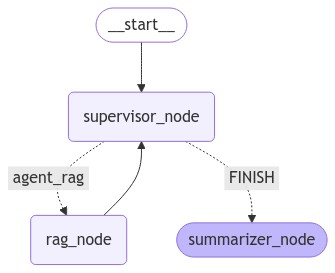

In [74]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [79]:
graph.invoke({"question": "quien es Fabian?"})

Next agent: agent_rag
Agent says: Fabian Alejandro Massotto es un ingeniero que está realizando su Trabajo Final para la Carrera de Especialización en Inteligencia Artificial.
Summarizing...


{'question': 'quien es Fabian?',
 'agent_rag': 'Fabian Alejandro Massotto es un ingeniero que está realizando su Trabajo Final para la Carrera de Especialización en Inteligencia Artificial.',
 'answer': 'Fabian Alejandro Massotto es un ingeniero que está realizando su Trabajo Final para la Carrera de Especialización en Inteligencia Artificial.'}